# Overview

In this notebook, we attempt to improve our base CNN model performance by creating additional CNN models that are solely trained on subsets of classes that the base CNN model struggles with differentiating more.

The approach is as follows:
1. Train the base CNN.
2. Use the trained CNN to evaluate the training data.
3. From the confusion matrix, select the classes with the lowest precision (model struggles with these classes more) and determine which classes they are confused with (its significant false positives).
4. For each of these low precision classes and the classes it is confused with, train an additional CNN model. *For example, if the base CNN notably misclassifies many Dresses and Coats as Shirts, then Shirts will have a large number of false positives. We then train an additional CNN on Dresses, Coats and Shirts only, such that when the base CNN predicts a Shirt, we then input the image to this additional CNN for a reprediction and use its output label as the final prediction.*

After the above is executed, we then have our final model whose execution flow is as follows:
1. For each image, run it through the base CNN.
2. If the predicted label is one of the classes that has low precision, it is more likely to be a false positive, so we input the image to the respective additional CNN and use its output label as the final prediction. Otherwise, simply use the base CNN output label as the prediction.

For the additional CNNs, we use the same architecture as the base CNN (apart from the output layer since the number of classes is now reduced). This should result in similar model complexities. Hence the intuition is that the additional CNNs should be able to have better performance and differentiate between classes better since they have similar model complexities to the base CNN but only have to deal with a fewer number of classes. If this indeed works, then we should expect an increase in overall performance since more of the base CNN's false positives will be caught by these additional CNNs and classified correctly instead.

# Imports

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [41]:
# torch.zeros(1).cuda() # Uncomment if your device supports cuda

# Main cNN

This is the base CNN. We will later compare our new model that is inclusive of the additional CNNs with the performance of this model to see if there is any improvement in performance.

## Import and Prepare Dataset

In [42]:
train_csv = pd.read_csv("./fashion-mnist_train.csv")
test_csv = pd.read_csv("./fashion-mnist_test.csv")

In [43]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
             # first column is of labels.
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [44]:
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_csv, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_csv, transform=transforms.Compose([transforms.ToTensor()]))

train_loader = DataLoader(train_set, batch_size=100)
test_loader = DataLoader(test_set, batch_size=100)

All the above has been done to load data in batches into the model. We use the DataLoader class from torch.utils.data.

The FashionDataset class has two methods: 
- get_item(index) -> image and label of item at index
- len() -> number of items in the dataset

In [45]:
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [46]:
# Mapping label number to a more meaningful label

def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

## Main cNN Model

1. Make a model class (inherits nn.Module class)
2. Add Layers to model class

    a. Convolution layer with kernel size 3*3, padding = 1 (no padding) in 1st layer and padding = 0 in second layer. Stride of 1 in both layers.

    b. Batch normalization layer

    c. Activation function used: ReLU

    d. Max Pooling layer with kernel size of 2 * 2 and stride 2.

        i. flatten out output for dense layer

        ii. 3 fully connected layers with different in/out features

        iii. 1 dropout layer with p=0.25

Summary is as follows:

First conv layer -> First maxpool layer -> Second conv layer -> Second maxpool layer

28 * 28 * 1 --Conv layer 1--> 28 * 28 * 32 --Maxpool layer 1--> 14 * 14 * 32 --Conv layer 2--> 12 * 12 * 64 --Maxpool layer 2--> 6 * 6 * 64

Final fully connected layer has 10 output features for 10 types of clothes.

In [47]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [48]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


Method to train the model:

In [49]:
train_accu = []
train_losses = []

def train(model, optimizer, loader, epoch):
  model.train()

  running_loss=0
  correct=0
  total=0
  
  for images, labels in loader:
    # Transfering images and labels to GPU if available
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass 
    outputs = model(images)
    loss = error(outputs, labels)
    
    # Initializing a gradient as 0 so there is no mixing of gradient among the batches
    optimizer.zero_grad()
    
    #Propagating the error backward
    loss.backward()
    
    # Optimizing the parameters
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(loader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  return train_loss, accu

Method to test the model:

In [50]:
eval_losses=[]
eval_accu=[]
 
def test(model, loader, epoch):
  model.eval()
 
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for images, labels in loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images)
      loss = error(outputs, labels)

      running_loss += loss.item()

      _, predictions = outputs.max(1)
      total += labels.size(0)
      correct += predictions.eq(labels).sum().item()
   
  test_loss=running_loss/len(loader)
  accu=100.*correct/total
 
  eval_losses.append(test_loss)
  eval_accu.append(accu)
 
  return test_loss, accu

We train the base CNN for 100 epochs:

In [51]:
epochs=100
train_accu, eval_accu, train_losses, eval_losses = [], [], [], []
for epoch in range(1,epochs+1):
  train_loss, train_accuracy = train(model, optimizer, train_loader, epoch)
  test_loss, test_accuracy = test(model, test_loader, epoch)
  print("Epoch: {}\nTrain: Loss: {}, Accuracy: {}%\nTest: Loss {}, Accuracy: {}%".format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
  

Epoch: 1
Train: Loss: 0.43636564751466117, Accuracy: 84.48333333333333%
Test: Loss 0.4573469008505344, Accuracy: 84.06%
Epoch: 2
Train: Loss: 0.29925518088042735, Accuracy: 89.28833333333333%
Test: Loss 0.33221115052700045, Accuracy: 88.45%
Epoch: 3
Train: Loss: 0.26195639022936423, Accuracy: 90.64666666666666%
Test: Loss 0.2642047929018736, Accuracy: 90.71%
Epoch: 4
Train: Loss: 0.23541583801309268, Accuracy: 91.46166666666667%
Test: Loss 0.23573233462870122, Accuracy: 91.68%
Epoch: 5
Train: Loss: 0.2196872045782705, Accuracy: 92.18%
Test: Loss 0.23380145773291588, Accuracy: 91.9%
Epoch: 6
Train: Loss: 0.2001614577199022, Accuracy: 92.84666666666666%
Test: Loss 0.23604259587824344, Accuracy: 91.93%
Epoch: 7
Train: Loss: 0.18758819910387198, Accuracy: 93.27833333333334%
Test: Loss 0.23590892054140566, Accuracy: 92.01%
Epoch: 8
Train: Loss: 0.17203820878639817, Accuracy: 93.86666666666666%
Test: Loss 0.24669233694672585, Accuracy: 91.73%
Epoch: 9
Train: Loss: 0.1626791895988087, Accurac

## Graphs of accuracy / loss vs. number of epochs

In [52]:
import os

if not os.path.exists('./diagrams'):
    os.makedirs('./diagrams')

Train accuracy and Test accuracy against number of epochs:

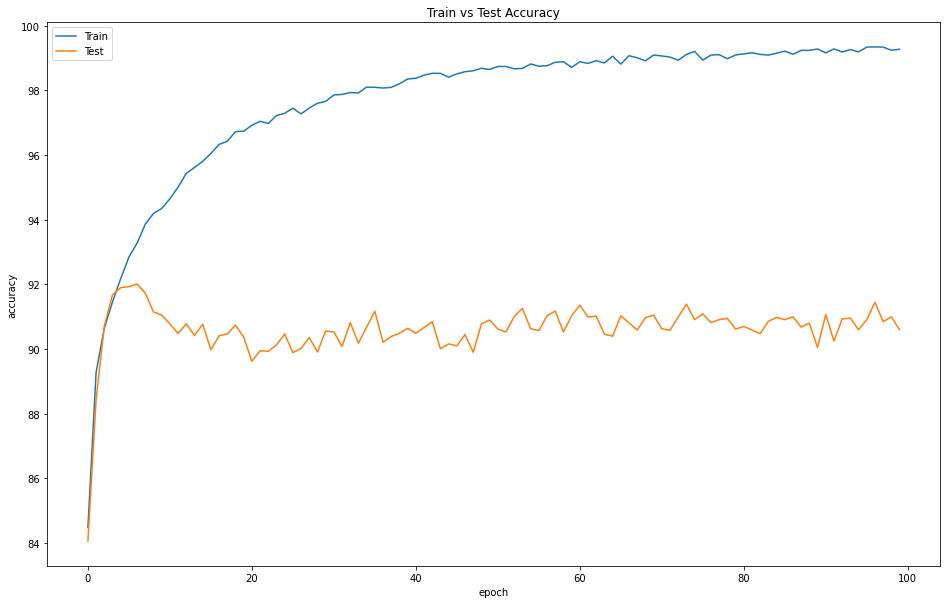

In [53]:
plt.figure(figsize=(16,10))

plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')

plt.savefig('./diagrams/cNN_Train_vs_Valid_Acc.png')

Train loss and Test loss against number of epochs:

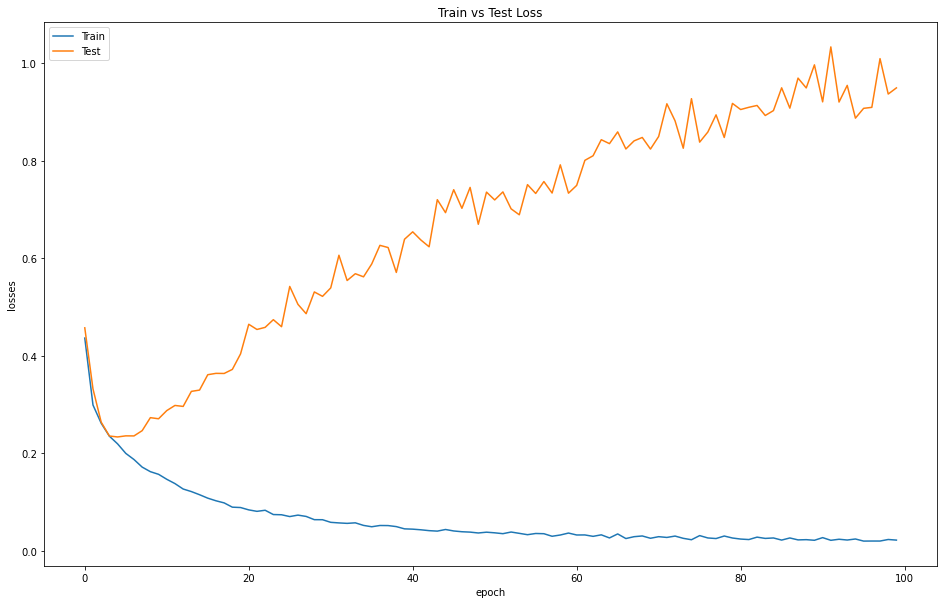

In [54]:
plt.figure(figsize=(16,10))

plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Loss')
 
plt.savefig('./diagrams/cNN_Train_vs_Valid_loss.png')

From the graph above we can see a downward trend of training loss vs epoch. Perhaps a reason for the slight spikes in loss could be due to the randomness of the batch sampling. An unlucky sampling could have led to the loss increasing compared to the previous iterations but overall the loss has a downward trend as iterations increase.

However, test loss decreased for the first 7 epochs or so, then generally increased with more and more epochs. This is likely due to the model overfitting the training data with more and more epochs.

Correspondingly, we notice that training accuracy generally increases with more epochs, reaching around 99%, but test accuracy increases up to around 92% after 7 or so epochs, then drops and fluctuates around 90% for the rest of the epochs.

Note that we do not use such findings from our test data to adjust the model, so as to not data snoop. For now, with our overfitted model, we can expect test accuracies to be generally lower than training accuracies.

From our findings, we plan to do the following given more time in the future:
We should randomly split the training data into training and validation data and plot the same graphs as above. From those graphs, we can find the point at which validation loss reaches a minimum (before continuously climbing for the rest of the epochs). That indicates the number of epochs for which we should train the model so as to not overfit the data greatly. There are other steps that we can take to reduce overfitting as well, such as adjusting the dropout rate.

## Training Evaluation

Observe the model's performance on the training data

In [55]:
all_labels = torch.Tensor();
all_predicted = torch.Tensor();

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))

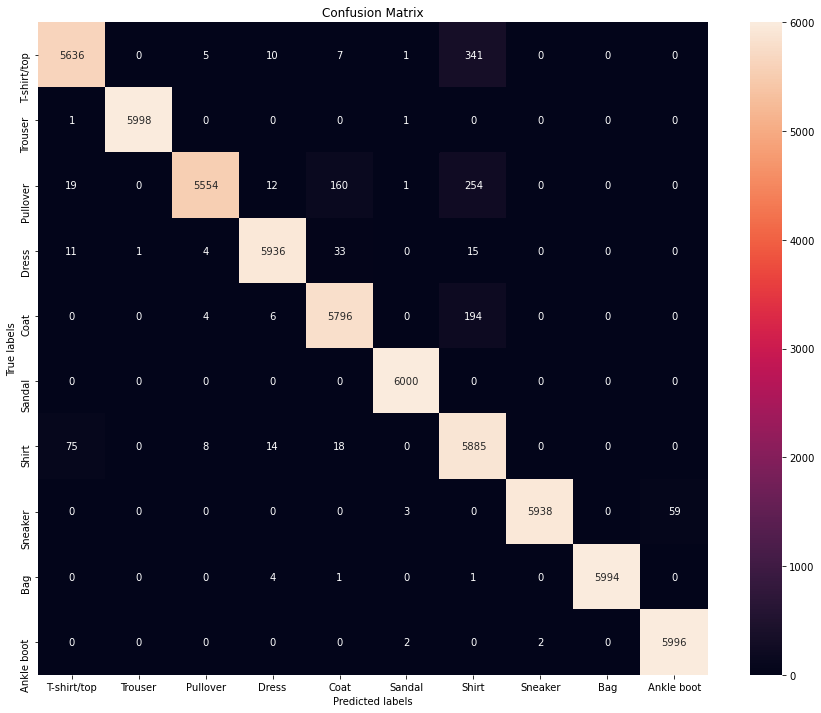

In [56]:
cm = confusion_matrix(all_labels, all_predicted)

fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_labels);
ax.yaxis.set_ticklabels(class_labels);

In [57]:
precision_train = [0 for _ in range(len(class_labels))]

cr = classification_report(all_labels, all_predicted, target_names=class_labels, output_dict=True)
for i in range(len(cr) - 3):
  precision_train[i] = cr[list(cr)[i]]['precision']

f1_score_train = cr['weighted avg']['f1-score']

print(classification_report(all_labels, all_predicted, target_names=class_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.98      0.94      0.96      6000
     Trouser       1.00      1.00      1.00      6000
    Pullover       1.00      0.93      0.96      6000
       Dress       0.99      0.99      0.99      6000
        Coat       0.96      0.97      0.96      6000
      Sandal       1.00      1.00      1.00      6000
       Shirt       0.88      0.98      0.93      6000
     Sneaker       1.00      0.99      0.99      6000
         Bag       1.00      1.00      1.00      6000
  Ankle boot       0.99      1.00      0.99      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



## Test Evaluation

Observe the model's performance on the test data

In [58]:
all_labels = torch.Tensor();
all_predicted = torch.Tensor();

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))

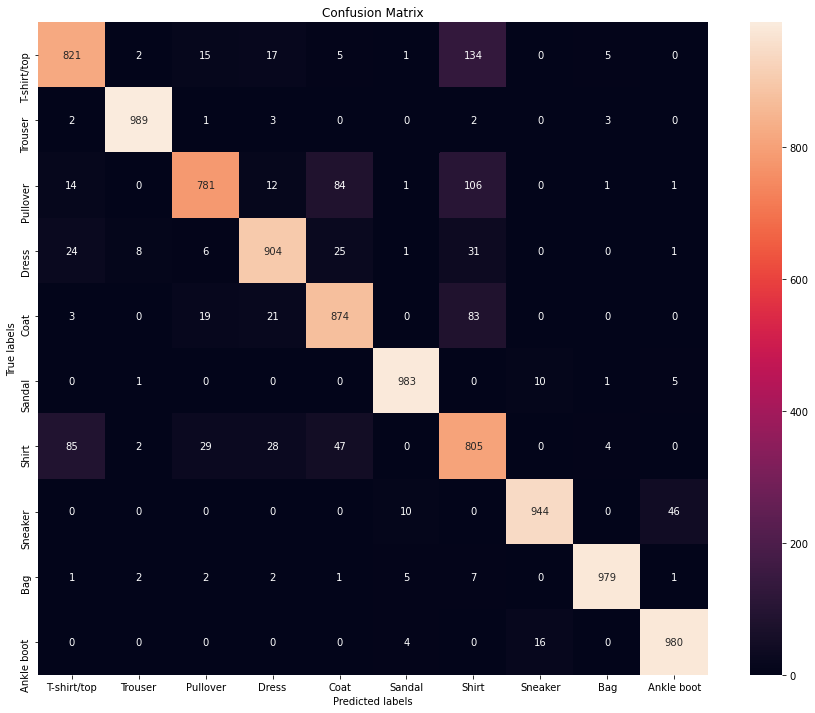

In [59]:
cm = confusion_matrix(all_labels, all_predicted)

fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_labels);
ax.yaxis.set_ticklabels(class_labels);

In [60]:
precision_test = [0 for _ in range(len(class_labels))]

cr = classification_report(all_labels, all_predicted, target_names=class_labels, output_dict=True)
for i in range(len(cr) - 3):
  precision_test[i] = cr[list(cr)[i]]['precision']

f1_score_test = cr['weighted avg']['f1-score']

print(classification_report(all_labels, all_predicted, target_names=class_labels))

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.82      0.84      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.92      0.78      0.84      1000
       Dress       0.92      0.90      0.91      1000
        Coat       0.84      0.87      0.86      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.69      0.81      0.74      1000
     Sneaker       0.97      0.94      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.95      0.98      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



## Evaluation Analysis

From the above evaluation on training data, we can find the classes with the lowest precision and find which classes they are most confused with (their significant false positives):

**From Training Data:**

Classes with the lowest precision:

| Class       | Precision (%)   | Classes that it is most confused with (its significant false positives) |
|-------------|-----------------|-------------------------------------------------------------------------|
| Shirt       | 88              | T-shirt/Top, Pullover, Coat                                             |
| Coat        | 96              | Pullover, Dress                                                         |
| T-shirt/Top | 98              | Shirt                                                                   |

From the table above, we can then train these 3 additional CNN models:
1. Trained on T-shirt/Top, Pullover, Coat and Shirt. Class likely to be false positive: Shirt.
2. Trained on Pullover, Dress, Coat. Class likely to be false positive: Coat.
3. Trained on T-shirt/Top and Shirt. Class likely to be false positive: T-shirt/Top.

<br />
<br />

*Note: Findings from test data below are solely for understanding purposes and are not used to change the model so as to not data snoop*

**From Test Data:**

Classes with the lowest precision:

| Class       | Precision (%)   | Classes that it is most confused with (its significant false positives) |
|-------------|-----------------|-------------------------------------------------------------------------|
| Shirt       | 69              | T-shirt/top, Pullover, Coat                                             |
| Coat        | 84              | Pullover, Dress, Shirt                                                  |
| T-shirt/top | 86              | Shirt                                                                   |

We notice that the classes in the table above are very similar to that of the table on training data above. This shows that the classes that the model struggles with in the test set is roughly similar to that in the training set. We can thus expect the model to generalise on the test set. We note that to improve upon these findings, we should split the training set into a training and validation set and use the validation set for the above findings in place of the test set. This way, we can keep the test set purely for testing purposes and prevent ourselves from data snooping.

# Additional cNNs

## Create and Train Additional cNNs

In [65]:
# For each low precision class and the classes that it is confused with, train an additional CNN model on those classes

confused_classes1 = [0, 6] # T-shirt/Top (0) might be Shirt (6)
confused_classes2 = [2, 3, 4] # Coat (4) might be Pullover (2) or Dress (3)
confused_classes3 = [0, 2, 4, 6] # Shirt (6) might be T-shirt/Top (0), Pullover (2) or Coat (4)
confused_classes = [confused_classes1, confused_classes2, confused_classes3]

# Maps from index in confused_class to its class and vice versa
confused_classes1_to_index_map, confused_classes2_to_index_map, confused_classes3_to_index_map = {}, {}, {}
index_to_confused_classes1_map, index_to_confused_classes2_map, index_to_confused_classes3_map = {}, {}, {}
maps = [[confused_classes1_to_index_map, index_to_confused_classes1_map], [confused_classes2_to_index_map, index_to_confused_classes2_map], [confused_classes3_to_index_map, index_to_confused_classes3_map]]

idx = 0
for confused_class in confused_classes:
  for i in range(len(confused_class)):
    maps[idx][0][confused_class[i]] = i
    maps[idx][1][i] = confused_class[i]
  idx += 1

# Train and test subsets of data that only contain images of the respective groups of confused classes
train_csv_subset1, train_csv_subset2, train_csv_subset3  = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
train_csv_subsets = [train_csv_subset1, train_csv_subset2, train_csv_subset3]

test_csv_subset1, test_csv_subset2, test_csv_subset3 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
test_csv_subsets = [test_csv_subset1, test_csv_subset2, test_csv_subset3]

idx = 0
for confused_class in confused_classes:
  train_csv_subsets[idx] = train_csv[train_csv.label.isin(confused_class)]
  test_csv_subsets[idx] = test_csv[test_csv.label.isin(confused_class)]
  idx += 1

train_subset1, train_subset2, train_subset3 = [], [], []
train_subsets = [train_subset1, train_subset2, train_subset3]

test_subset1, test_subset2, test_subset3 = [], [], []
test_subsets = [test_subset1, test_subset2, test_subset3]

train_subset_loader1, train_subset_loader2, train_subset_loader3 = [], [], []
train_subset_loaders = [train_subset_loader1, train_subset_loader2, train_subset_loader3]

test_subset_loader1, test_subset_loader2, test_subset_loader3 = [], [], []
test_subset_loaders = [test_subset_loader1, test_subset_loader2, test_subset_loader3]

for i in range(len(confused_classes)):
  train_csv_subsets[i]['label'] = train_csv_subsets[i]['label'].map(lambda x: maps[i][0][x])
  test_csv_subsets[i]['label'] = test_csv_subsets[i]['label'].map(lambda x: maps[i][0][x])

  train_subsets[i] = FashionDataset(train_csv_subsets[i], transform=transforms.Compose([transforms.ToTensor()]))
  test_subsets[i] = FashionDataset(test_csv_subsets[i], transform=transforms.Compose([transforms.ToTensor()]))

  train_subset_loaders[i] = DataLoader(train_subsets[i], batch_size=100)
  test_subset_loaders[i] = DataLoader(test_subsets[i], batch_size=100)

<ipython-input-65-12ca615a1535>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_csv_subsets[i]['label'] = train_csv_subsets[i]['label'].map(lambda x: maps[i][0][x])
<ipython-input-65-12ca615a1535>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_csv_subsets[i]['label'] = test_csv_subsets[i]['label'].map(lambda x: maps[i][0][x])


In [66]:
class FashionCNN2(nn.Module):
    def __init__(self, num_classes):
        super(FashionCNN2, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [67]:
model1, model2, model3 = [], [], []
extra_models = [model1, model2, model3]

optimizer1, optimizer2, optimizer3 = [], [], []
optimizers = [optimizer1, optimizer2, optimizer3]

for i in range(len(confused_classes)):
  extra_models[i] = FashionCNN2(len(confused_classes[i]))
  extra_models[i].to(device)
  optimizers[i] = torch.optim.Adam(extra_models[i].parameters(), lr=learning_rate)

Train each additional CNN for 100 epochs:

In [68]:
epochs=100
train_accu, eval_accu, train_losses, eval_losses = [], [], [], []
for i in range(len(confused_classes)):
  print("Extra Model #{}".format(i))
  for epoch in range(1,epochs+1):
    train_loss, train_accuracy = train(extra_models[i], optimizers[i], train_subset_loaders[i], epoch)
    test_loss, test_accuracy = test(extra_models[i], test_subset_loaders[i], epoch)
    print("Epoch: {}\nTrain: Loss: {}, Accuracy: {}%\nTest: Loss {}, Accuracy: {}%".format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
  

Extra Model #0
Epoch: 1
Train: Loss: 0.4514961411555608, Accuracy: 81.125%
Test: Loss 0.3250173173844814, Accuracy: 85.1%
Epoch: 2
Train: Loss: 0.3086747230341037, Accuracy: 86.225%
Test: Loss 0.2962775774300098, Accuracy: 86.7%
Epoch: 3
Train: Loss: 0.27916625204185647, Accuracy: 87.95833333333333%
Test: Loss 0.2854098342359066, Accuracy: 87.3%
Epoch: 4
Train: Loss: 0.2604596734046936, Accuracy: 88.74166666666666%
Test: Loss 0.27508982717990876, Accuracy: 87.8%
Epoch: 5
Train: Loss: 0.24244325427959362, Accuracy: 89.65833333333333%
Test: Loss 0.2678220711648464, Accuracy: 88.45%
Epoch: 6
Train: Loss: 0.24344556468228498, Accuracy: 89.65%
Test: Loss 0.2978334456682205, Accuracy: 86.95%
Epoch: 7
Train: Loss: 0.22119473951558272, Accuracy: 90.81666666666666%
Test: Loss 0.269625274091959, Accuracy: 88.45%
Epoch: 8
Train: Loss: 0.20894957383473714, Accuracy: 91.19166666666666%
Test: Loss 0.28260955587029457, Accuracy: 88.2%
Epoch: 9
Train: Loss: 0.18921674527227877, Accuracy: 92.2333333333

## Individual Model Evaluation

For each individual additional CNN, we observe changes in model performance (precision) as compared to the base CNN

In [69]:
indiv_model_class_labels = [['T-shirt/Top', 'Shirt'], ['Pullover', 'Dress', 'Coat'], ['T-shirt/Top', 'Pullover', 'Coat', 'Shirt']]

### Training Evaluation


Extra Model #0
Precision of T-shirt/Top: 0.97%, Change: -0.01%
Precision of Shirt: 1.00%, Change: 0.12%
Total precision change: 0.11%

Extra Model #1
Precision of Pullover: 1.00%, Change: 0.00%
Precision of Dress: 1.00%, Change: 0.01%
Precision of Coat: 0.95%, Change: -0.02%
Total precision change: -0.01%

Extra Model #2
Precision of T-shirt/Top: 0.97%, Change: -0.01%
Precision of Pullover: 0.98%, Change: -0.02%
Precision of Coat: 1.00%, Change: 0.03%
Precision of Shirt: 1.00%, Change: 0.12%
Total precision change: 0.12%


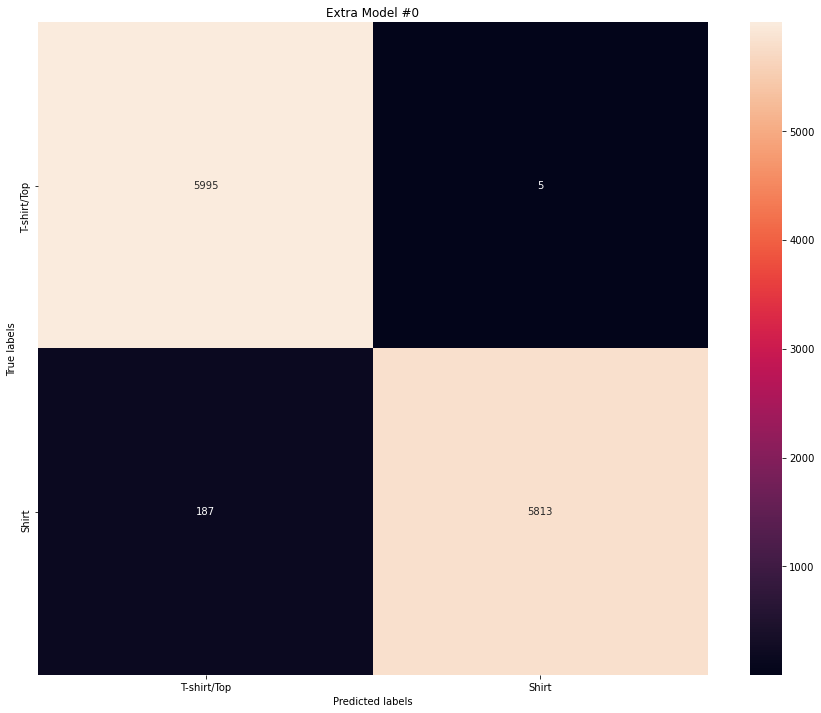

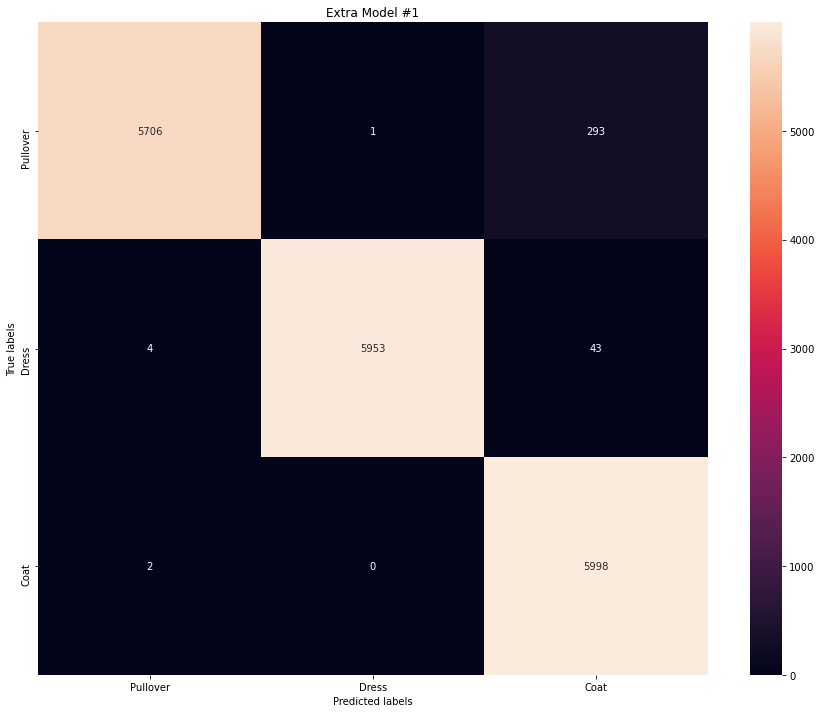

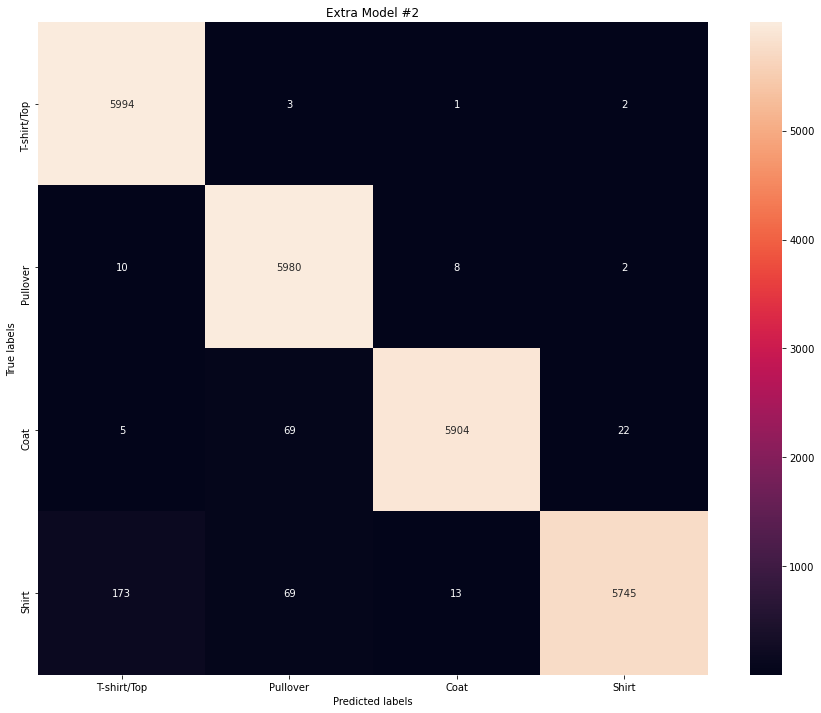

In [70]:
for i in range(len(confused_classes)):
    print("\nExtra Model #{}".format(i))

    num_classes = len(confused_classes[i])

    all_labels = torch.Tensor()
    all_predicted = torch.Tensor()

    with torch.no_grad():
        for images, labels in train_subset_loaders[i]:
            images, labels = images.to(device), labels.to(device)
            outputs = extra_models[i](images)
            _, predicted = outputs.max(1)
            c = (predicted == labels).squeeze()

            all_labels = torch.cat((all_labels, labels))
            all_predicted = torch.cat((all_predicted, predicted))

    cr = classification_report(all_labels, all_predicted, target_names=indiv_model_class_labels[i], output_dict=True)
    total_precision_change = 0
    for j in range(num_classes):
        k = maps[i][1][j] # index to class map
        precision_new = cr[list(cr)[j]]['precision']
        precision_change = precision_new - precision_train[k]
        total_precision_change += precision_change
        print("Precision of {}: {:.2f}%, Change: {:.2f}%".format(output_label(k), precision_new, precision_change))
    print("Total precision change: {:.2f}%".format(total_precision_change))

    cm = confusion_matrix(all_labels, all_predicted)

    fig, ax = plt.subplots(figsize=(15,12))

    sns.heatmap(cm, annot=True, fmt='g', ax=ax); # annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Extra Model #{}'.format(i));
    ax.xaxis.set_ticklabels(indiv_model_class_labels[i]);
    ax.yaxis.set_ticklabels(indiv_model_class_labels[i]);

### Test Evaluation


Extra Model #0
Precision of T-shirt/Top: 0.83%, Change: -0.03%
Precision of Shirt: 0.92%, Change: 0.23%
Total precision change: 0.19%

Extra Model #1
Precision of Pullover: 0.96%, Change: 0.04%
Precision of Dress: 0.97%, Change: 0.05%
Precision of Coat: 0.85%, Change: 0.00%
Total precision change: 0.09%

Extra Model #2
Precision of T-shirt/Top: 0.82%, Change: -0.04%
Precision of Pullover: 0.85%, Change: -0.07%
Precision of Coat: 0.89%, Change: 0.05%
Precision of Shirt: 0.83%, Change: 0.14%
Total precision change: 0.09%


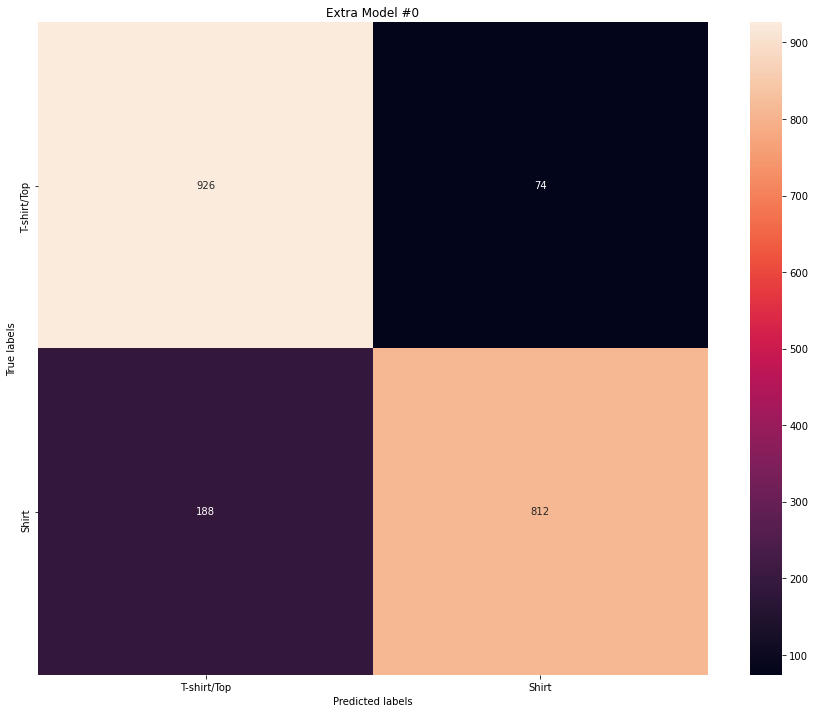

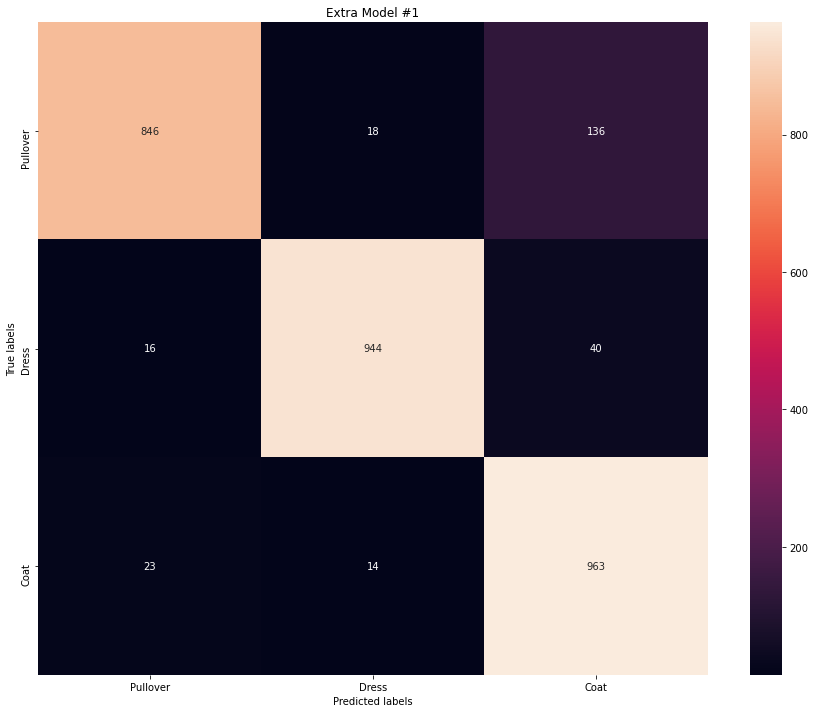

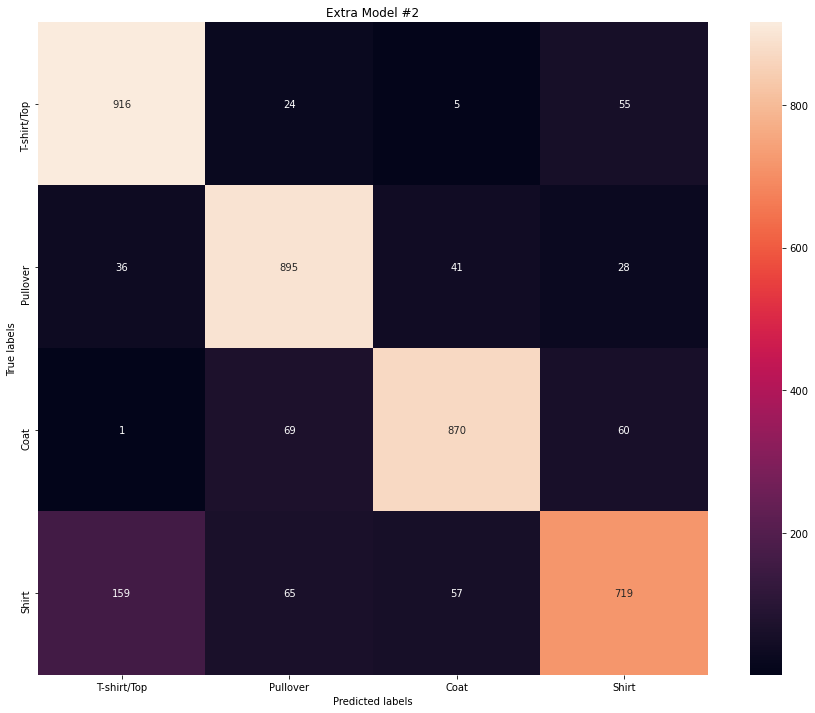

In [71]:
for i in range(len(confused_classes)):
    print("\nExtra Model #{}".format(i))

    num_classes = len(confused_classes[i])

    all_labels = torch.Tensor()
    all_predicted = torch.Tensor()

    with torch.no_grad():
        for images, labels in test_subset_loaders[i]:
            images, labels = images.to(device), labels.to(device)
            outputs = extra_models[i](images)
            _, predicted = outputs.max(1)
            c = (predicted == labels).squeeze()

            all_labels = torch.cat((all_labels, labels))
            all_predicted = torch.cat((all_predicted, predicted))
    
    cr = classification_report(all_labels, all_predicted, target_names=indiv_model_class_labels[i], output_dict=True)
    total_precision_change = 0
    for j in range(num_classes):
        k = maps[i][1][j] # index to class map
        precision_new = cr[list(cr)[j]]['precision']
        precision_change = precision_new - precision_test[k]
        total_precision_change += precision_change
        print("Precision of {}: {:.2f}%, Change: {:.2f}%".format(output_label(k), precision_new, precision_change))
    print("Total precision change: {:.2f}%".format(total_precision_change))
    
    cm = confusion_matrix(all_labels, all_predicted)

    fig, ax = plt.subplots(figsize=(15,12))

    sns.heatmap(cm, annot=True, fmt='g', ax=ax); # annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Extra Model #{}'.format(i));
    ax.xaxis.set_ticklabels(indiv_model_class_labels[i]);
    ax.yaxis.set_ticklabels(indiv_model_class_labels[i]);

In [72]:
low_precision_classes = [0, 4, 6]
class_to_model_idx_mapping = {0: 0, 4: 1, 6: 2} # for each low precision class, map it to the additional CNN model it should use

## Training Evaluation

Now using both the base CNNs as well as additional CNNs (i.e. our final model design)

In [73]:
all_labels = torch.Tensor()
all_predicted = torch.Tensor()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        # if the batch of predicted results includes a prediction of a low precision class

        for i in range(len(low_precision_classes)):
            if low_precision_classes[i] in predicted:
                # run the batch through the additional CNN for that specific low precision class
                outputs_new = extra_models[class_to_model_idx_mapping[low_precision_classes[i]]](images)
                _, predicted_new = outputs_new.max(1)
                # swap out predictions for the low prediction class from the base model for predictions from the additional model
                predicted_temp = predicted
                index = 0
                for j in predicted:
                    if j == low_precision_classes[i]:
                        # swap the old prediction for the one from the additional model
                        predicted_temp[index] = maps[class_to_model_idx_mapping[low_precision_classes[i]]][1][predicted_new[index].item()] # idx to class map
                    index += 1
                predicted = predicted_temp

        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))

cr = classification_report(all_labels, all_predicted, target_names=class_labels, output_dict=True)
total_precision_change = 0
for i in range(10):
    precision_new = cr[list(cr)[i]]['precision']
    precision_change = precision_new - precision_train[i]
    total_precision_change += precision_change
    print("Precision of {}: {:.2f}%, Change: {:.2f}%".format(output_label(i), precision_new, precision_change))

print("Total precision change: {:.2f}%".format(total_precision_change))

Precision of T-shirt/Top: 0.97%, Change: -0.02%
Precision of Trouser: 1.00%, Change: 0.00%
Precision of Pullover: 0.98%, Change: -0.01%
Precision of Dress: 0.99%, Change: -0.00%
Precision of Coat: 0.99%, Change: 0.02%
Precision of Sandal: 1.00%, Change: 0.00%
Precision of Shirt: 1.00%, Change: 0.12%
Precision of Sneaker: 1.00%, Change: 0.00%
Precision of Bag: 1.00%, Change: 0.00%
Precision of Ankle Boot: 0.99%, Change: 0.00%
Total precision change: 0.11%


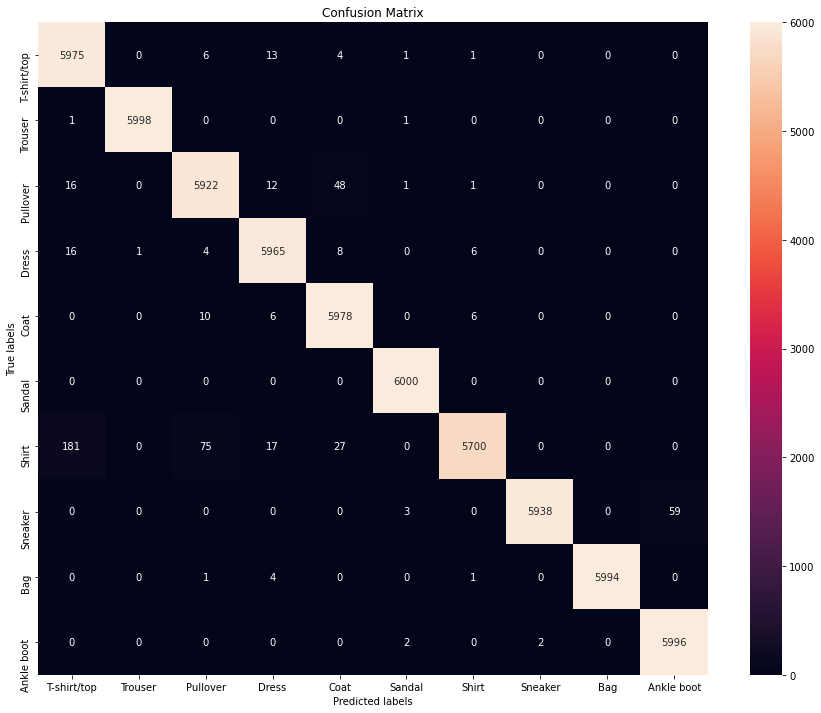

In [74]:
cm = confusion_matrix(all_labels, all_predicted)

fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(cm, annot=True, fmt='g', ax=ax); # annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_labels);
ax.yaxis.set_ticklabels(class_labels);

In [75]:
print(classification_report(all_labels, all_predicted, target_names=class_labels))
f1_score_train_new = cr['weighted avg']['f1-score']
print("F1-score change: {:.2f}%".format(f1_score_train_new - f1_score_train))

              precision    recall  f1-score   support

 T-shirt/top       0.97      1.00      0.98      6000
     Trouser       1.00      1.00      1.00      6000
    Pullover       0.98      0.99      0.99      6000
       Dress       0.99      0.99      0.99      6000
        Coat       0.99      1.00      0.99      6000
      Sandal       1.00      1.00      1.00      6000
       Shirt       1.00      0.95      0.97      6000
     Sneaker       1.00      0.99      0.99      6000
         Bag       1.00      1.00      1.00      6000
  Ankle boot       0.99      1.00      0.99      6000

    accuracy                           0.99     60000
   macro avg       0.99      0.99      0.99     60000
weighted avg       0.99      0.99      0.99     60000

F1-score change: 0.01%


## Test Evaluation

In [76]:
all_labels = torch.Tensor()
all_predicted = torch.Tensor()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        # if the batch of predicted results includes a prediction of a low precision class

        for i in range(len(low_precision_classes)):
            if low_precision_classes[i] in predicted:
                # run the batch through the additional CNN for that specific low precision class
                outputs_new = extra_models[class_to_model_idx_mapping[low_precision_classes[i]]](images)
                _, predicted_new = outputs_new.max(1)
                # swap out predictions for the low prediction class from the base model for predictions from the additional model
                predicted_temp = predicted
                index = 0
                for j in predicted:
                    if j == low_precision_classes[i]:
                        # swap the old prediction for the one from the additional model
                        predicted_temp[index] = maps[class_to_model_idx_mapping[low_precision_classes[i]]][1][predicted_new[index].item()] # idx to class map
                    index += 1
                predicted = predicted_temp

        c = (predicted == labels).squeeze()

        all_labels = torch.cat((all_labels, labels))
        all_predicted = torch.cat((all_predicted, predicted))

cr = classification_report(all_labels, all_predicted, target_names=class_labels, output_dict=True)
total_precision_change = 0
for i in range(10):
    precision_new = cr[list(cr)[i]]['precision']
    precision_change = precision_new - precision_test[i]
    total_precision_change += precision_change
    print("Precision of {}: {:.2f}%, Change: {:.2f}%".format(output_label(i), precision_new, precision_change))

print("Total precision change: {:.2f}%".format(total_precision_change))

Precision of T-shirt/Top: 0.81%, Change: -0.05%
Precision of Trouser: 0.99%, Change: 0.00%
Precision of Pullover: 0.86%, Change: -0.05%
Precision of Dress: 0.91%, Change: -0.01%
Precision of Coat: 0.85%, Change: 0.01%
Precision of Sandal: 0.98%, Change: 0.00%
Precision of Shirt: 0.86%, Change: 0.17%
Precision of Sneaker: 0.97%, Change: 0.00%
Precision of Bag: 0.99%, Change: 0.00%
Precision of Ankle Boot: 0.95%, Change: 0.00%
Total precision change: 0.07%


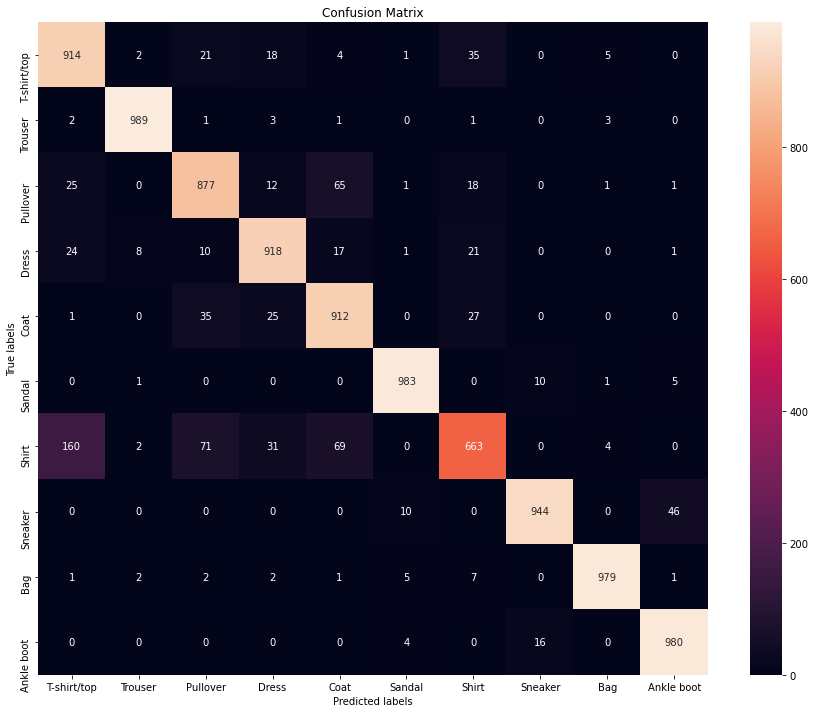

In [77]:
cm = confusion_matrix(all_labels, all_predicted)

fig, ax = plt.subplots(figsize=(15,12))

sns.heatmap(cm, annot=True, fmt='g', ax=ax); # annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(class_labels);
ax.yaxis.set_ticklabels(class_labels);

In [78]:
print(classification_report(all_labels, all_predicted, target_names=class_labels))
f1_score_test_new = cr['weighted avg']['f1-score']
print("F1-score change: {:.2f}%".format(f1_score_test_new - f1_score_test))

              precision    recall  f1-score   support

 T-shirt/top       0.81      0.91      0.86      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.91      0.92      0.91      1000
        Coat       0.85      0.91      0.88      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.86      0.66      0.75      1000
     Sneaker       0.97      0.94      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.95      0.98      0.96      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.91     10000
weighted avg       0.92      0.92      0.91     10000

F1-score change: 0.01%


# Conclusion